<a href="https://colab.research.google.com/github/KacperGrodecki/image_proccessing/blob/main/kuba_img_text_reading_found_words_analyzing_enchant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip uninstall spacy

In [ ]:
pip install spacy==2.3.2

In [ ]:
!python3 -m spacy download pl_core_news_md
#https://github.com/explosion/spaCy/issues/5140

In [ ]:
import spacy  
from spacy.lang.pl.examples import sentences 
nlp = spacy.load("pl_core_news_md")

In [2]:
pip install pyenchant

In [3]:
!apt install -qq enchant

enchant is already the newest version (1.6.0-11.1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [4]:
!apt-get install myspell-pl

Reading package lists... Done
Building dependency tree       
Reading state information... Done
myspell-pl is already the newest version (20170707-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [5]:
import pandas as pd
import cv2
import numpy as np
import re
import matplotlib.pyplot as plt      
import pickle
from os import listdir
from os.path import isfile, join
import gc
import sys
import pickle
import string
import enchant
from time import time
from gensim.models.phrases import Phrases, Phraser
from collections import defaultdict  # For word frequency
import multiprocessing
from gensim.models import Word2Vec

In [6]:
d = enchant.Dict('PL')
d.check("guzik") # False



True

In [7]:
text=pd.read_csv('drive/MyDrive/kuba/odczyt_0_85.csv',index_col=0)

In [8]:
text.head()

,0
0,drive/MyDrive/kuba/zdjecia/fig1.jpg
1,Własność\narchiwum\nAktotwórca\nTytuł teczki\n...
2,IPN BU 0 639/223
3,KARTA INFORMACYJNA
4,Instytut Pamięci Narodowej w Warszawie


In [9]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [10]:
def has_numbers(inputString):
    return any(char.isdigit() for char in inputString)

In [55]:
ch='/'
ch.isalnum()

False

In [56]:
def word_correction_enchant(a):
    a=str(a)
    if 'drive/MyDrive/kuba/' in a:
      return a
    correct=''
    for word in a.split():
        word = ''.join(ch for ch in word if ch.isalnum())
        if len(word)>1:
            if has_numbers(word) or len(word)<3:
              continue
            try:
              if int(d.check(word))==1:
                correct+=word.lower()+' '
            except:
              pass     
    return correct

In [57]:
correct=text.applymap(lambda x: word_correction_enchant(x))#dodać numery stron

In [58]:
correct1 = correct[correct['0']!= '']

In [59]:
print(correct1.iloc[300:400].values)

[['współpracy ']
 ['kosi ']
 ['blokowymi ']
 ['przy ']
 ['przy pół ']
 ['poprzez ']
 ['poprzez ']
 ['śluby terenowe ']
 ['terenowe ']
 ['cechuje ']
 ['cechuje ']
 ['chaotyczność ']
 ['winne ']
 ['linia polityczną pax ']
 ['linia polityczną pań ']
 ['drive/MyDrive/kuba/zdjecia/fig112.jpg']
 ['ipn ']
 ['lei ']
 ['celu ']
 ['tezy ']
 ['wania pracy radach ']
 ['pak ']
 ['specjalne ']
 ['racuch ']
 ['inf ']
 ['drive/MyDrive/kuba/zdjecia/fig113.jpg']
 ['załącznik zestawu ważniejszych ']
 ['załącznik zestawu ważniejszych ']
 ['informacji ']
 ['spotkanie pax ']
 ['aktywem katolickim katowicach ']
 ['stowarzyszenie pax zorganizowało katowicach spotkanie ']
 ['rzymskiego korespondenta pax redaktora czajkowskiego ']
 ['temat wizyty ministra ']
 ['księżmi działaczami świeckimi temat wizyty ministra watykanie ']
 ['wzięli udział zajmujący się paxie ']
 ['pracą duchowieństwem przewodniczący oddziału ']
 ['członkowie sekretariatu ']
 ['kiego katowicach ']
 ['osób tym księży diec krakowskiej często ']

In [130]:
def nazwiska(x):
  if 'gołębiewski' in x:
    return 1
  else:
    return 0

In [143]:
kuba=correct1.copy()

In [144]:
kuba['swoje']=kuba.applymap(lambda x: nazwiska(x))

In [166]:
print(kuba[kuba['swoje']==1])
kuba.iloc[5720:5720+30,:]

                 0  swoje
7408  gołębiewski       1


,0,swoje
7364,ipn,0
7369,dziełu,0
7370,iata loli pre zych,0
7372,załączeniu dot,0
7373,zarządu oddziału stowarzyszenia pax,0
7374,odbytej,0
7375,roku,0
7386,said fran,0
7388,adresat,0
7393,drive/MyDrive/kuba/zdjecia/fig278.jpg,0


In [19]:
#https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

In [60]:
df=correct1.copy()

In [61]:
def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    #if len(txt) > 2:
    return ' '.join(txt)

In [62]:
brief_cleaning = (str(row).lower() for row in df['0'])

In [63]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.12 mins


In [100]:
nlp_txt='. '.join(txt)
doc = nlp(nlp_txt)

In [111]:
#https://realpython.com/natural-language-processing-spacy-python/#part-of-speech-tagging
surnames=[]
for token in doc:
  if token.pos_=='NOUN' and ('ski' in token.text or 'cki' in token.text):
    surnames.append(token.text)
    

In [116]:
for token in doc:
  if 'gołębiewski' in token.text:
    print(token.text)

gołębiewski


In [113]:
set_surnames=set(surnames)

In [64]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(7960, 1)

In [65]:
print(correct1.iloc[370:420].values)

[['osobistego wkładu papieża oraz szacunkiem mówił ']
 ['katolicy polsce wspólnie budują socjalizm ']
 ['konsekwencją wizyty min olszowskiego watykanie ']
 ['będą dalsze rozmowy między polską watykanem ']
 ['zaproszenie przyjazd casaroli polski ']
 ['które rokują nadzieje osiągnięcie porozumień ']
 ['bazie poszanowania konstytucji przepisów przez ']
 ['kościół wolności religijnej przez państwo ']
 ['prasa włoska światowa wytworzyła odpowiedni klimat ']
 ['rozmów którego nie mogły zakłócić ']
 ['nawet koła rewizjonistów konserwatystów zarzucały one ']
 ['papieżowi czyni zbyt wiele gestów pod adresem komu ']
 ['rozbestwia ich psuje posoborową atmosferę ']
 ['kościele potęguje kryzys atmosfera wytrąciła ']
 ['argumenty kościele cierpiącym milczącym ']
 ['zachodzie przez niektórych hierarchów polskich ']
 ['zdaniem red czajkowskiego polsce ']
 ['normalizacji stosunków widzi papież ']
 ['watykan polska dotychczas była wyspą kościele którą ']
 ['omijały negatywne zjawiska kontestacji obojętn

In [66]:
df_clean.values[300:350]

array([['ziemia likwidacja ambasada rząd londyński'],
       ['watykanie odmówienie akredytacja rozmowa'],
       ['podjąć polski nominacja karda kominek spotkanie'],
       ['helsinkach'],
       ['uzgodnić wspólny działanie polski'],
       ['rzecz pokój wyrazić chęć'],
       ['stosunki reda czajkowski uważać'],
       ['przełom polski znaleźć orbi'],
       ['wpływ polityka watykański'],
       ['drive / mydrive / kuba / zdjecia / fig114.jpg'],
       ['wizyta mina olszowskiego watykanie przebiegać'],
       ['atmosfera szukania punkt zbliżenie unikania sprawa'],
       ['móc doprowadzić zadrażnienie stosunki'],
       ['polski watykanem papież wyrazić szacunek kraj'],
       ['socjalistyczny polityka używać słowo partia'],
       ['polski rzeczpospolita ludowy mina olszowski wyrazić'],
       ['uznanie polityka pojednanie pokój watykanu'],
       ['osobisty wkład papież szacunek mówić'],
       ['katolik polsce wspólnie budować socjalizm'],
       ['konsekwencja wizyta mina olszow

In [84]:
def surnames(text):
  if 'ski' in text:
    print(text)

In [67]:
sent = [row.split() for row in df_clean['clean']]

In [68]:
phrases = Phrases(sent, min_count=5, progress_per=100)

In [69]:
bigram = Phraser(phrases)

In [70]:
sentences = bigram[sent]

In [71]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

6774

In [177]:
surnames_freq = defaultdict(int)
for sent in surnames:
        surnames_freq[sent] += 1
len(surnames_freq)

58

In [179]:
sorted(surnames_freq, key=word_freq.get, reverse=True)

['polski',
 'duszpasterski',
 'piasecki',
 'czajkowski',
 'wyszyński',
 'wyszyńskiego',
 'poselski',
 'marksistowski',
 'marksowski',
 'rekowski',
 'białeckiego',
 'uzyskiwania',
 'uzyskiwanie',
 'żydowski',
 'piaseckiego',
 'skierowanie',
 'wrocławski',
 'antyradziecki',
 'prometejski',
 'frankowski',
 'szczepanowski',
 'jaroszewskiego',
 'czajkowskiego',
 'olszowski',
 'dąbrowskiego',
 'starowiejski',
 'zagórski',
 'kudliński',
 'drozdowski',
 'ziembiński',
 'dybowski',
 'gąsowski',
 'pozyskiwania',
 'puławski',
 'zabłockiego',
 'troski',
 'ski',
 'brodowskiego',
 'piaseckim',
 'gołębiewski',
 'balicki',
 'różycki',
 'markowskim',
 'markowski',
 'markowskiego',
 'lipiński',
 'morawskiego',
 'sułkowski',
 'prusiński',
 'jabłoński',
 'moczyński',
 'skizy',
 'brodowski',
 'dębski',
 'janicki',
 'jankowski',
 'wójcicki',
 'rostworowski']

In [185]:
sorted(word_freq, key=word_freq.get, reverse=True)

['drive_/',
 'mydrive_/',
 'kuba_/',
 'zdjecia_/',
 'praca',
 'pax',
 'człowiek',
 'działalność',
 'stowarzyszenie',
 'sprawa',
 'rozwój',
 'kraj',
 'swój',
 'należeć',
 'kościół',
 'polityczny',
 'społeczny',
 'społeczeństwo',
 'dzień',
 'partia',
 'nowy',
 'rola',
 'polski',
 'problem',
 'rzecz',
 'życie',
 'państwo',
 'wartość',
 'sytuacja',
 'referat',
 'osoba',
 'polsce',
 'dyskusja',
 'rok',
 'zadanie',
 'członek',
 'poprzez',
 'stosunek',
 'katolicki',
 'gospodarczy',
 'potrzeba',
 'władza',
 'świat',
 'okres',
 'naród',
 'cena',
 'zostać',
 'rucho',
 'katolik',
 'stowarzyszenie_pax',
 'który',
 'socjalizm',
 'istnieć',
 'teza',
 'cel',
 'socjalistyczny',
 'kultura',
 'bóg',
 'wielki',
 'pozycja',
 'wzrost',
 'światopoglądowy',
 'grupa',
 'polityka',
 'prowadzić',
 'mówić',
 'postawa',
 'nasz',
 'proces',
 'organizacja',
 'księża',
 'uwaga',
 'dot',
 'wobec',
 'część',
 'działanie',
 'związek',
 'narodowy',
 'zmiana',
 'aktywność',
 'produkcja',
 'zakres',
 'stanowić',
 'czas',


In [187]:
pd_word_freq=pd.DataFrame.from_dict(word_freq, orient='index')

In [192]:
pd_word_freq_sorted=pd_word_freq.sort_values(by=[0], ascending=False)

In [194]:
pd_word_freq_sorted.head(20)

,0
drive_/,345
kuba_/,345
zdjecia_/,345
mydrive_/,345
praca,268
pax,254
człowiek,142
działalność,136
stowarzyszenie,131
sprawa,127


In [74]:
cores = multiprocessing.cpu_count()

In [75]:
w2v_model = Word2Vec(min_count=4,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [76]:
t = time()

w2v_model.build_vocab(sentences, progress_per=100)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.01 mins


In [77]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.09 mins


In [78]:
w2v_model.init_sims(replace=True)

In [79]:
word_freq['czajkowski']

5

In [80]:
w2v_model.wv.most_similar(positive=["czajkowski"])

[('projekt', 0.9999195337295532),
 ('przewodniczący', 0.9999194145202637),
 ('era', 0.9999194145202637),
 ('kabat', 0.9999192953109741),
 ('własny', 0.99991774559021),
 ('zawierać', 0.9999170303344727),
 ('biskup', 0.9999169111251831),
 ('nakaz', 0.9999165534973145),
 ('teoria', 0.999916136264801),
 ('winna', 0.999916136264801)]

In [180]:
w2v_model.wv.most_similar(positive=["piasecki"])

[('główny', 0.9999316930770874),
 ('brak', 0.9999307990074158),
 ('jeden', 0.99992835521698),
 ('miejsce', 0.9999279975891113),
 ('gospodarczy', 0.9999275207519531),
 ('żyć', 0.9999270439147949),
 ('ocena', 0.999925434589386),
 ('działo', 0.9999251961708069),
 ('rząd', 0.9999251365661621),
 ('stowarzyszenie_pax', 0.9999251365661621)]

In [181]:
w2v_model.wv.most_similar(positive=["wyszyński"])

[('rodzina', 0.9999311566352844),
 ('uważać', 0.9999282956123352),
 ('karty', 0.9999276995658875),
 ('biskup', 0.9999265670776367),
 ('zdanie', 0.9999260902404785),
 ('uchwała', 0.9999260902404785),
 ('stworzenie', 0.9999258518218994),
 ('informacja', 0.9999257922172546),
 ('stowarzyszenie_pax', 0.9999257922172546),
 ('określony', 0.9999251365661621)]

In [183]:
w2v_model.wv.most_similar(positive=["radziecki"])

[('dodatkowy', 0.9999371767044067),
 ('społecznie', 0.9999332427978516),
 ('sam', 0.9999316930770874),
 ('stan', 0.9999316930770874),
 ('zsrr', 0.9999301433563232),
 ('zgoda', 0.9999300837516785),
 ('kierownictwo', 0.999929666519165),
 ('głównie', 0.999929666519165),
 ('element', 0.9999295473098755),
 ('chrześcijanin', 0.999928891658783)]

In [184]:
w2v_model.wv.most_similar(negative=["radziecki"])

[('mal', 0.08305196464061737),
 ('mod', 0.03705967962741852),
 ('zero', 0.009060031734406948),
 ('bal', -0.10609574615955353),
 ('wada', -0.9646069407463074),
 ('jaga', -0.9989528059959412),
 ('dow', -0.9994471073150635),
 ('kuba_/', -0.999703049659729),
 ('jaz', -0.999730110168457),
 ('ministerstwo', -0.9997433423995972)]

In [47]:
w2v_model.wv.doesnt_match(['pax', 'socjalizm', 'chrze_cija'])

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'socjalizm'

In [48]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=18).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

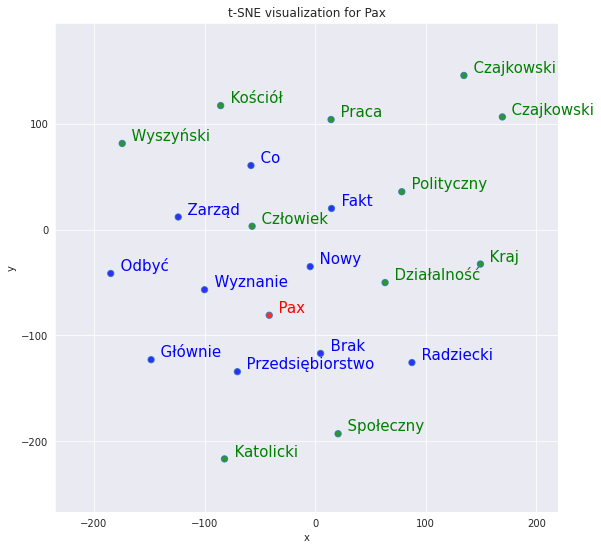

In [182]:
tsnescatterplot(w2v_model, 'pax', ['praca', 'działalność', 'człowiek', 'polityczny', 'kraj', 'kościół', 'społeczny','katolicki','czajkowski',
                                   'czajkowski','wyszyński'])